In [6]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter
import lightkurve as lk
import pandas as pd

In [7]:
import warnings
warnings.filterwarnings("ignore") # bloody theano subtensor warnings ..

In [11]:
koi = pd.read_csv('../../data/koi_dsct.csv')
koi[['kepid','koi_period', 'koi_disposition']]
# # row = koi[koi['kepid'] == 9289704]
row = koi[koi['kepid'] == 5202905]
row

,Unnamed: 0,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err,dsct
3,3,5202905,K01932.01,Kepler-340 c,CONFIRMED,Done,16/8/18,CANDIDATE,0.944,0,...,0.22,0.32,0.23,-0.11,0.26,0.43,0.23,0.44,0.22,True
4,4,5202905,K01932.02,Kepler-340 b,CONFIRMED,Done,16/8/18,CANDIDATE,0.636,0,...,0.26,0.39,0.39,0.40,0.44,-0.15,0.25,0.43,0.40,True


In [22]:
koi_periods = row['koi_period'].values

In [14]:
lc = lk.search_lightcurvefile('KIC 5202905', mission='Kepler').download_all().PDCSAP_FLUX.stitch().remove_nans()

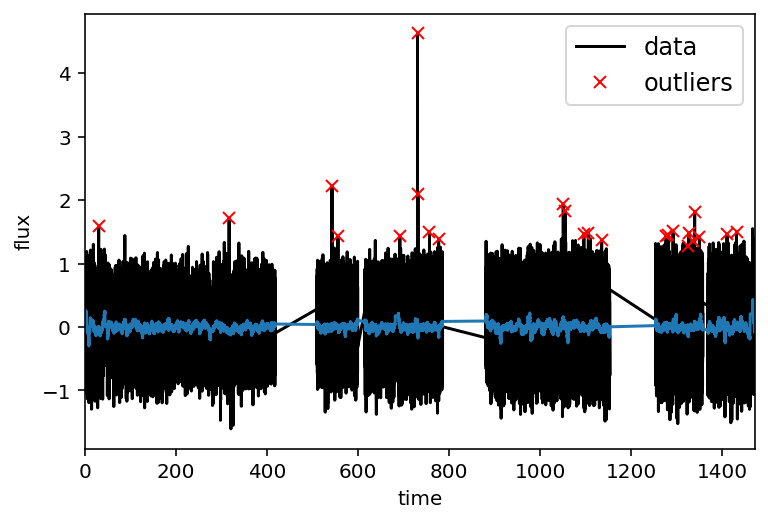

In [16]:
m = np.ones_like(lc.time, dtype=bool)
# Convert to parts per thousand
x = lc.time[m]
y = lc.flux[m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid ** 2))
    m0 = np.abs(resid) < 3 * sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

# Only discard positive outliers
m = resid < 3 * sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

plt.show()

In [23]:
from astropy.timeseries import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(koi_periods.min()-5), np.log(koi_periods.max()+5), 50000))
bls_results = []
periods = []
t0s = []
depths = []

for i in range(len(row)):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])

    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

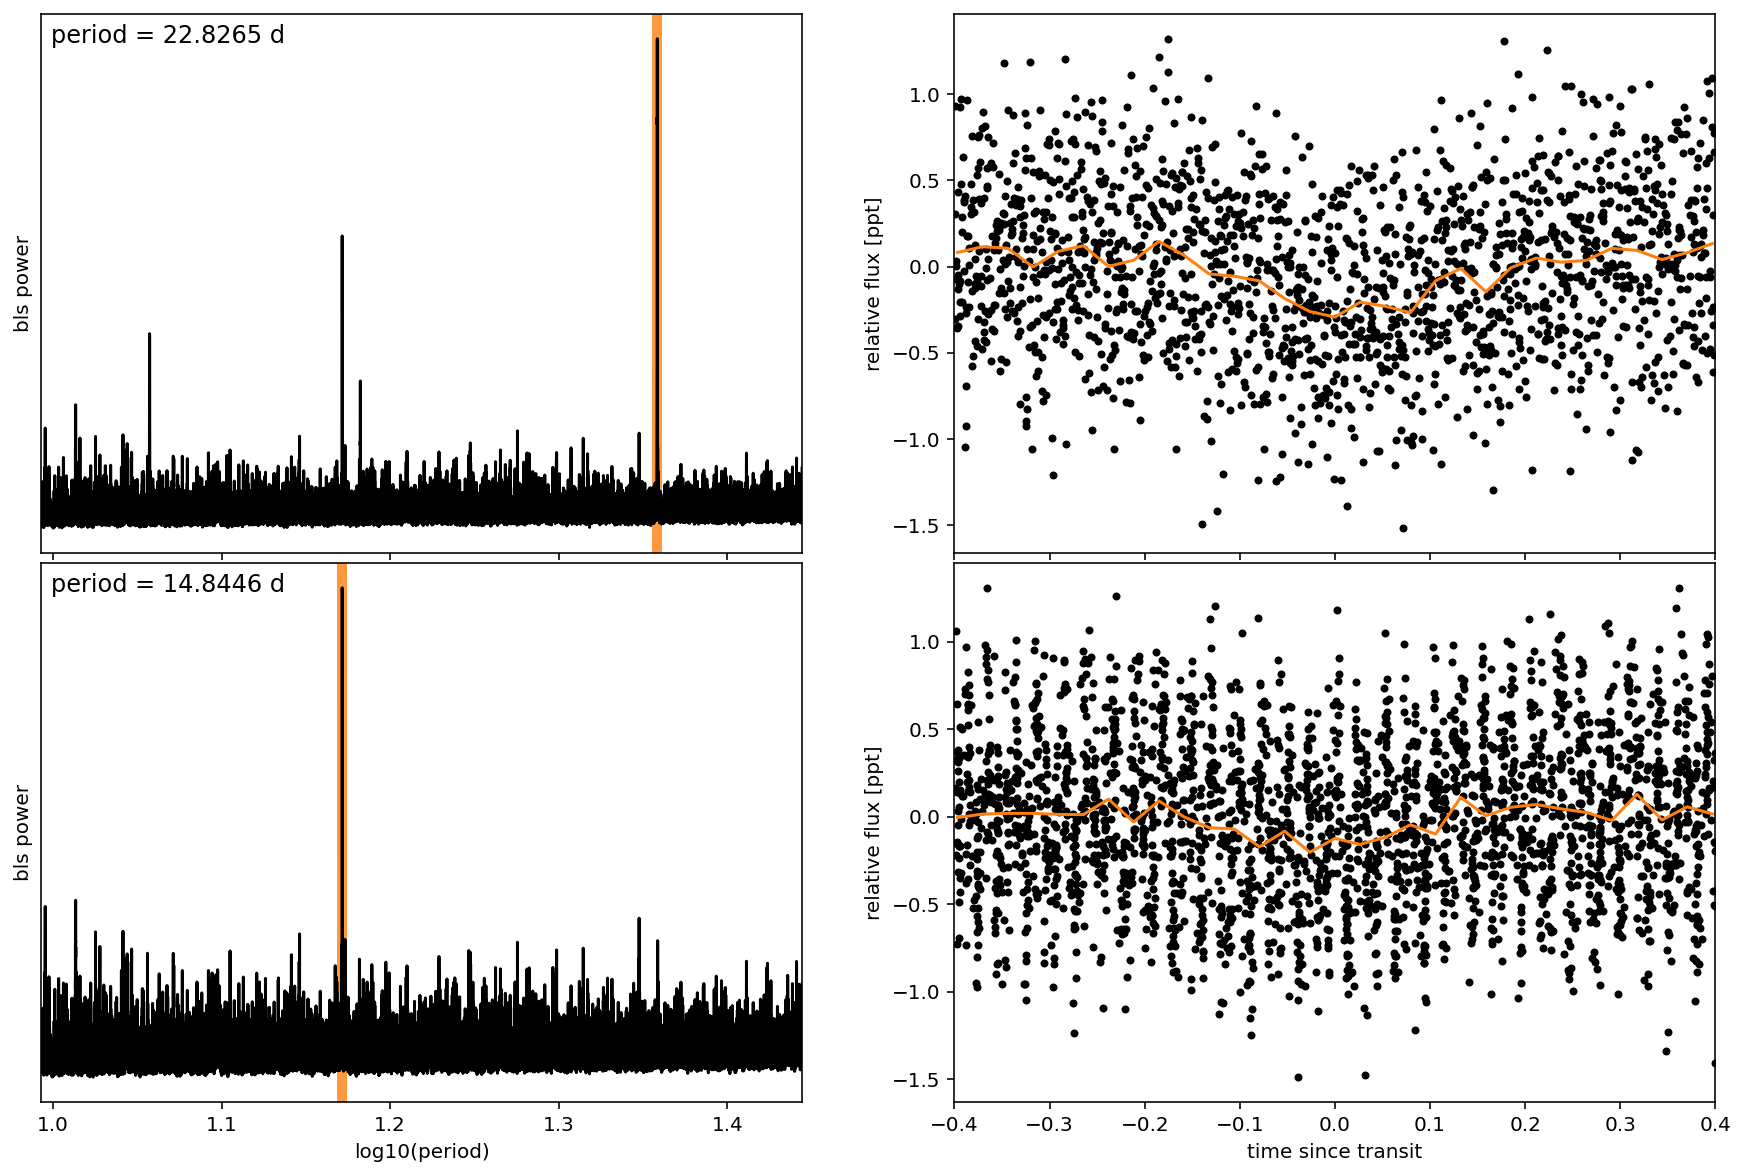

In [31]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate(
        "period = {0:.4f} d".format(periods[i]),
        (0, 1),
        xycoords="axes fraction",
        xytext=(5, -5),
        textcoords="offset points",
        va="top",
        ha="left",
        fontsize=12,
    )
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")

    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5 * p) % p - 0.5 * p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")

    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")

fig.subplots_adjust(hspace=0.02)

In [32]:
M_star = 1.421, 0.05
R_star = 1.846, 0.11

array([<matplotlib.axes._subplots.AxesSubplot object at 0x130382910>,
      dtype=object)

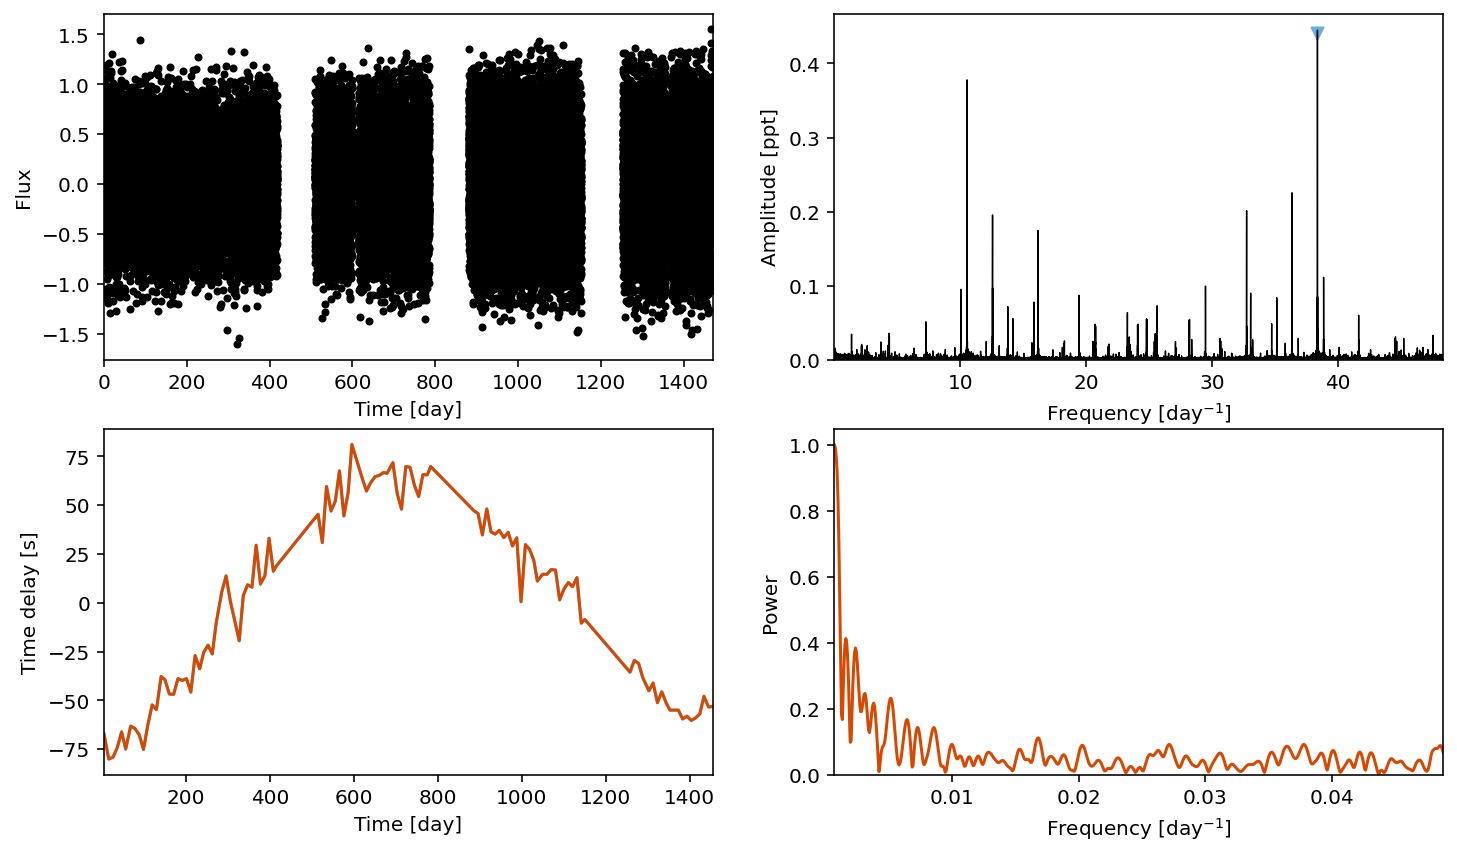

In [33]:
from maelstrom import Maelstrom
import exoplanet as xo

ms = Maelstrom(x, y / 1e3, fmin=10, fmax=40, max_peaks=1)
ms.first_look()

In [34]:
freq, weight = ms.freq, ms.get_weights(norm=False)

In [35]:
import astropy.units as u
msini = 1 * u.M_jup # Let's just wildly guess the mass

In [14]:
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])

        # Orbital parameters for the planets
        m_pl = pm.Bound(pm.Flat, lower=0)("m_pl", shape=1, testval=msini.value)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=1)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=1)
        logr = pm.Normal(
            "logr",
            mu=0.5 * np.log(1e-3 * np.array(depths)) + np.log(R_star[0]),
            sd=1.0,
            shape=1
        )
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = xo.ImpactParameter("b", ror=ror, shape=1)
#         b = xo.ImpactParameter("b", ror=r_pl, shape=1)

        ecs = xo.UnitDisk("ecs", shape=(2), testval=0.01 * np.ones((2)))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.vaneylen19("ecc_prior", shape=1, observed=ecc)
#         ecc = pm.Uniform('ecc', lower=0, upper=0.99, testval=0.01)
#         omega = xo.distributions.Angle('omega', testval=0.)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        
        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
#         a = pm.Uniform('a', lower=0, upper=100, testval=1)
#         m_pl = pm.Deterministic("m_pl", tt.exp(logm))
    
        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )
        
        # Compute the model light curve using starry
        def mean_model(t):
            light_curves = pm.Deterministic(
                "light_curves",
                xo.LimbDarkLightCurve(u_star).get_light_curve(
                    orbit=orbit, r=r_pl, t=t, #texp=texp
                )
                * 1e3,
            )
                
            return pm.math.sum(light_curves, axis=-1) + mean
        
#         # Pulsation timing model:
        lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
        phase = xo.distributions.Angle("phase", shape=len(freq))
        logamp = pm.Normal("logamp", mu=np.log(weight), sd=0.1, shape=len(freq),
                                         testval=np.log(weight))
        nu = pm.Deterministic("nu", tt.exp(lognu))
        asini_c = pm.Deterministic('asini/c', orbit.a_star * tt.sin(orbit.incl) * 695700000.0 / 299792458)
        
        def get_pulsation_model(t):
            sinf, cosf = orbit._get_true_anomaly(t)
            f = tt.arctan2(sinf, cosf)
            psi = (
                -1
                * (1 - tt.square(ecc))
                * tt.sin(f + omega)
                / (1 + ecc * tt.cos(f))
            )
            tau = pm.Deterministic('tau', (psi * asini_c) / 86400) # time delay in d
            pulsation_model = pm.Deterministic('pm_model', tt.sum(tt.exp(logamp)[None, :] * 
                                                                  tt.sin((2. * np.pi * nu) * 
                                                                    (t[:,None] - tau[:,None]) - phase[None, :]), 
                                                                  axis=1))
            return pulsation_model
        
        # GP model for the light curve
        logw0 = pm.Normal("logw0", mu=0.0, sd=10)
        logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y[mask])), sd=10)
        kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
        gp = xo.gp.GP(
            kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()),#mean=mean_model
        )
        
        gp.marginal("transit_obs", observed=y[mask] - mean_model(x[mask]) - get_pulsation_model(x[mask]))
        pm.Deterministic("gp_pred", gp.predict())
#         pm.Normal('obs', mu=get_pulsation_model(x[mask]) + mean_model(x[mask]), sd=tt.exp(logs2), observed=y[mask])
        
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[t0])
        map_soln = xo.optimize(start=map_soln, vars=[logamp, phase, lognu])
        map_soln = xo.optimize(start=start, vars=[logs2, logw0, logSw4])
        map_soln = xo.optimize(start=start, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[ecc, omega])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logamp])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln)
#         map_soln = xo.optimize(start=map_soln, vars=[m_pl, logr])
    
    return model, map_soln


model0, map_soln0 = build_model()

optimizing logp for variables: [t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -21731.70062116656 -> -21731.650519586517
optimizing logp for variables: [lognu, phase, logamp]


message: Desired error not necessarily achieved due to precision loss.
logp: -21731.650519586517 -> -21706.578813312863
optimizing logp for variables: [logSw4, logw0, logs2]


message: Optimization terminated successfully.
logp: -21731.700621166565 -> -16016.883695446691
optimizing logp for variables: [logs2]


message: Desired error not necessarily achieved due to precision loss.
logp: -21731.700621166565 -> -17351.38529360046
optimizing logp for variables: [b, logr, r_star]


message: Desired error not necessarily achieved due to precision loss.
logp: -17351.38529360046 -> -17295.925195753698
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -17295.925195753698 -> -17295.920680298204
optimizing logp for variables: [t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -17295.9206802982 -> -17259.9349916982
optimizing logp for variables: [logamp]


message: Desired error not necessarily achieved due to precision loss.
logp: -17259.934991698196 -> -17259.9325302332
optimizing logp for variables: [logr]


message: Optimization terminated successfully.
logp: -17259.932530233196 -> -17256.83082778308
optimizing logp for variables: [logSw4, logw0, logamp, phase, lognu, logs2, ecc_prior_frac, ecc_prior_sigma_rayleigh, ecc_prior_sigma_gauss, ecs, b, logr, t0, logP, m_pl, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -17256.830827783087 -> -15679.712447675505


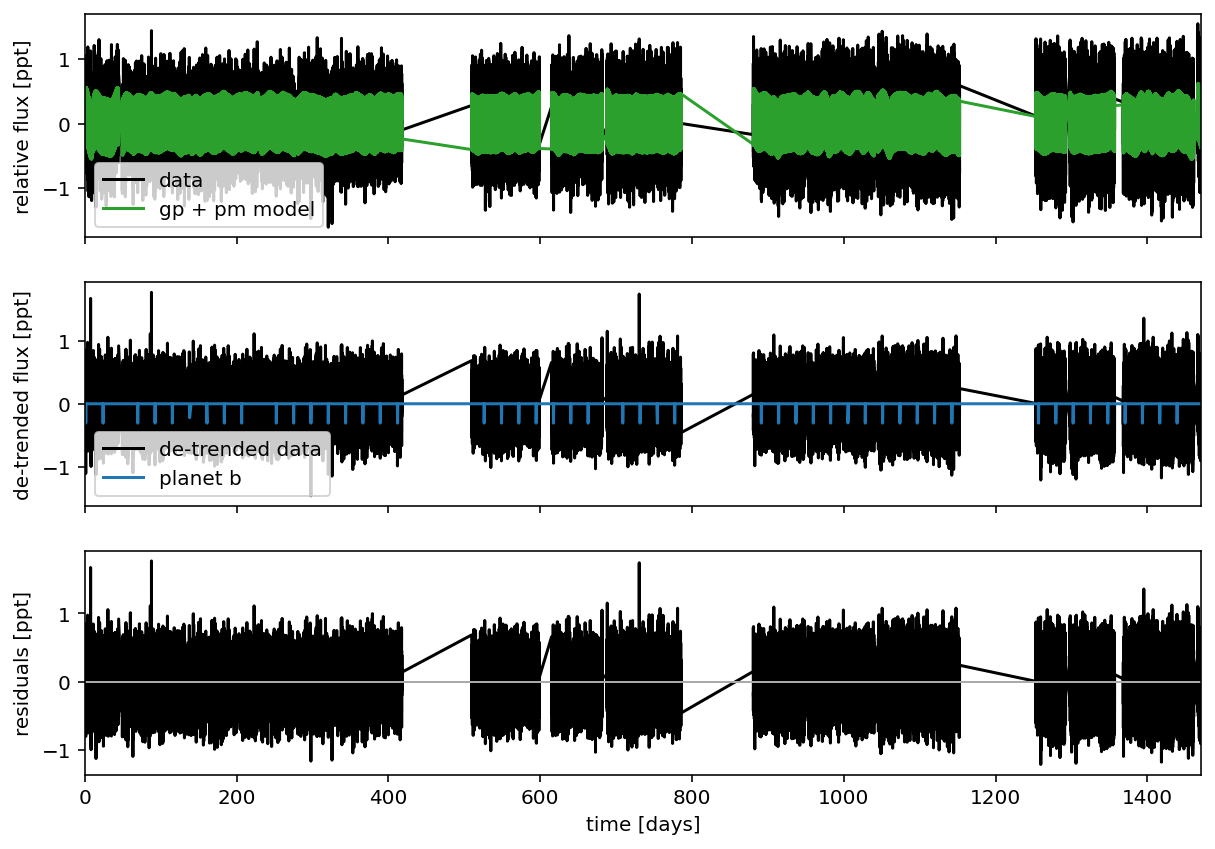

In [16]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"] + soln['pm_model']
    ax.plot(x[mask], gp_mod, color="C2", label="gp + pm model")
#     ax.plot(x[mask], soln['pm_model'], color='C3', alpha=0.7, label='pm model')
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig

plot_light_curve(map_soln0);

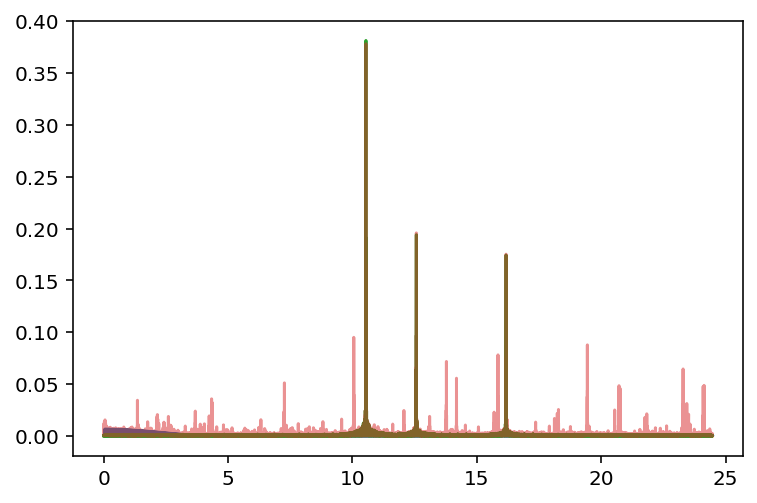

In [29]:
# from maelstrom.utils import amplitude_spectrum

# soln = map_soln0
# plt.plot(*amplitude_spectrum(x, np.sum(map_soln0["light_curves"], axis=-1)))
# plt.plot(*amplitude_spectrum(x, soln["gp_pred"]))
# plt.plot(*amplitude_spectrum(x, soln['pm_model']))

# plt.plot(*amplitude_spectrum(x, y), alpha=0.5)

Make sure my math checks out ...

In [20]:
from maelstrom.utils import mass_function

mf = mass_function(map_soln0['period']*u.day, np.abs(map_soln0['asini/c']) * u.s)
mass = (mf.to(u.M_jup))**(1/3) * ((map_soln0['m_star']*u.M_sun).to(u.M_jup))**(2/3)
mass[0]#.to(u.M_sun)

<Quantity 40.47772903 jupiterMass>

In [21]:
map_soln0

{'mean': array(0.00262873),
 'u_star_quadlimbdark__': array([-0.4177465 ,  0.11231604]),
 'm_star_interval__': array(-0.10154864),
 'r_star_interval__': array(0.43928878),
 'm_pl_lowerbound__': array([3.71927771]),
 'logP': array([3.12782948]),
 't0': array([1.10396287]),
 'logr': array([-3.50692699]),
 'b_impact__': array([0.16676285]),
 'ecs_unitdisk+interval__': array([0.02141011, 0.17477881]),
 'ecc_prior_sigma_gauss_lowerbound__': array(-3.0101819),
 'ecc_prior_sigma_rayleigh_lowerbound__': array(-1.31269322),
 'ecc_prior_frac_interval__': array(0.47875735),
 'logs2': array(-2.24478064),
 'lognu': array([3.6480037]),
 'phase_angle__': array([[-0.08685814],
        [ 4.47127023]]),
 'logamp': array([-0.8186992]),
 'logw0': array(-0.85424959),
 'logSw4': array(-8.59124284),
 'u_star': array([ 0.66547325, -0.03534936]),
 'm_star': array(1.4239039),
 'r_star': array(1.82426864),
 'm_pl': array([41.23460002]),
 'r_pl': array([0.02998893]),
 'ror': array([0.01643888]),
 'b': array([0.55

In [30]:
with model0:
    trace = pm.sample(
        tune=1000,
        draws=1000,
        start=map_soln0,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logamp, phase, lognu, logs2, ecc_prior_frac, ecc_prior_sigma_rayleigh, ecc_prior_sigma_gauss, ecs, b, logr, t0, logP, m_pl, r_star, m_star, u_star, mean]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [1:27:12<00:00,  1.31s/draws]  
The number of effective samples is smaller than 25% for some parameters.


In [31]:
pm.save_trace(trace, 'joint_model')

'joint_model'

In [32]:
trace.varnames

['mean',
 'u_star_quadlimbdark__',
 'm_star_interval__',
 'r_star_interval__',
 'm_pl_lowerbound__',
 'logP',
 't0',
 'logr',
 'b_impact__',
 'ecs_unitdisk+interval__',
 'ecc_prior_sigma_gauss_lowerbound__',
 'ecc_prior_sigma_rayleigh_lowerbound__',
 'ecc_prior_frac_interval__',
 'logs2',
 'lognu',
 'phase_angle__',
 'logamp',
 'u_star',
 'm_star',
 'r_star',
 'm_pl',
 'r_pl',
 'ror',
 'b',
 'ecs',
 'ecc',
 'omega',
 'ecc_prior_sigma_gauss',
 'ecc_prior_sigma_rayleigh',
 'ecc_prior_frac',
 'period',
 'phase',
 'nu',
 'asini/c',
 'tau',
 'pm_model',
 'light_curves']

In [42]:
pm.summary(trace, varnames=['mean',
 'logP',
 't0',
 'logr',
 'logs2',
 'u_star',
 'r_pl',
 'b',
 'ecs',
'm_pl',
 'ecc',
 'omega',
 'period',
                           'asini/c'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,0.001,0.001,-0.001,0.004,0.000,0.000,2368.0,1776.0,2376.0,1536.0,1.00
logP[0],3.128,0.000,3.128,3.128,0.000,0.000,1439.0,1439.0,1439.0,943.0,1.01
t0[0],1.105,0.007,1.093,1.118,0.000,0.000,1618.0,1618.0,1621.0,1273.0,1.01
logr[0],-3.535,0.091,-3.705,-3.368,0.003,0.002,802.0,796.0,803.0,1036.0,1.00
logs2,-1.115,0.003,-1.120,-1.109,0.000,0.000,2517.0,2517.0,2531.0,1020.0,1.00
u_star[0],0.671,0.401,0.002,1.328,0.012,0.009,1200.0,1074.0,1178.0,1088.0,1.00
u_star[1],0.048,0.397,-0.610,0.796,0.010,0.009,1448.0,1036.0,1377.0,1092.0,1.00
r_pl[0],0.029,0.003,0.024,0.034,0.000,0.000,826.0,826.0,803.0,1036.0,1.00
b[0],0.441,0.209,0.001,0.723,0.012,0.008,319.0,319.0,319.0,284.0,1.01
ecs[0],0.010,0.345,-0.626,0.656,0.012,0.011,789.0,517.0,754.0,655.0,1.00


(0.94, 1.0)

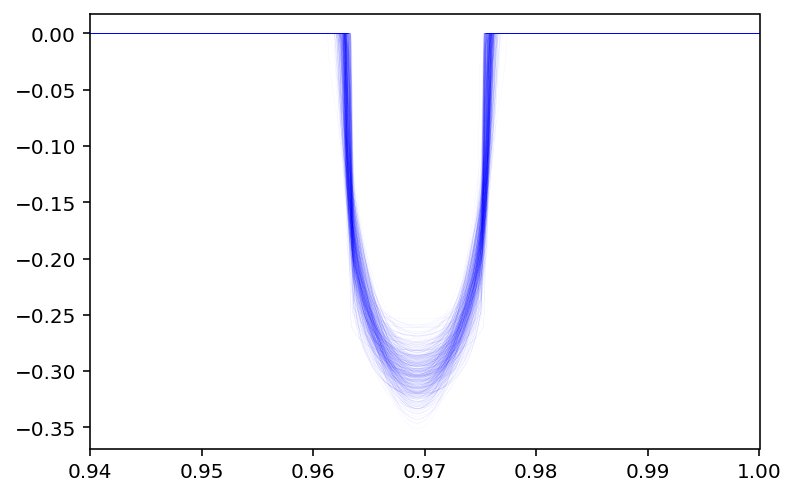

In [37]:
for samp in xo.get_samples_from_trace(trace, 500):
    phase = (x - samp['t0'] - 0.7) % samp['period'] / samp['period']
    sort = np.argsort(phase)
    plt.plot(phase[sort], samp['light_curves'][sort], c='blue', linewidth=0.1, alpha=0.1)
    
plt.xlim(0.94, 1.0)

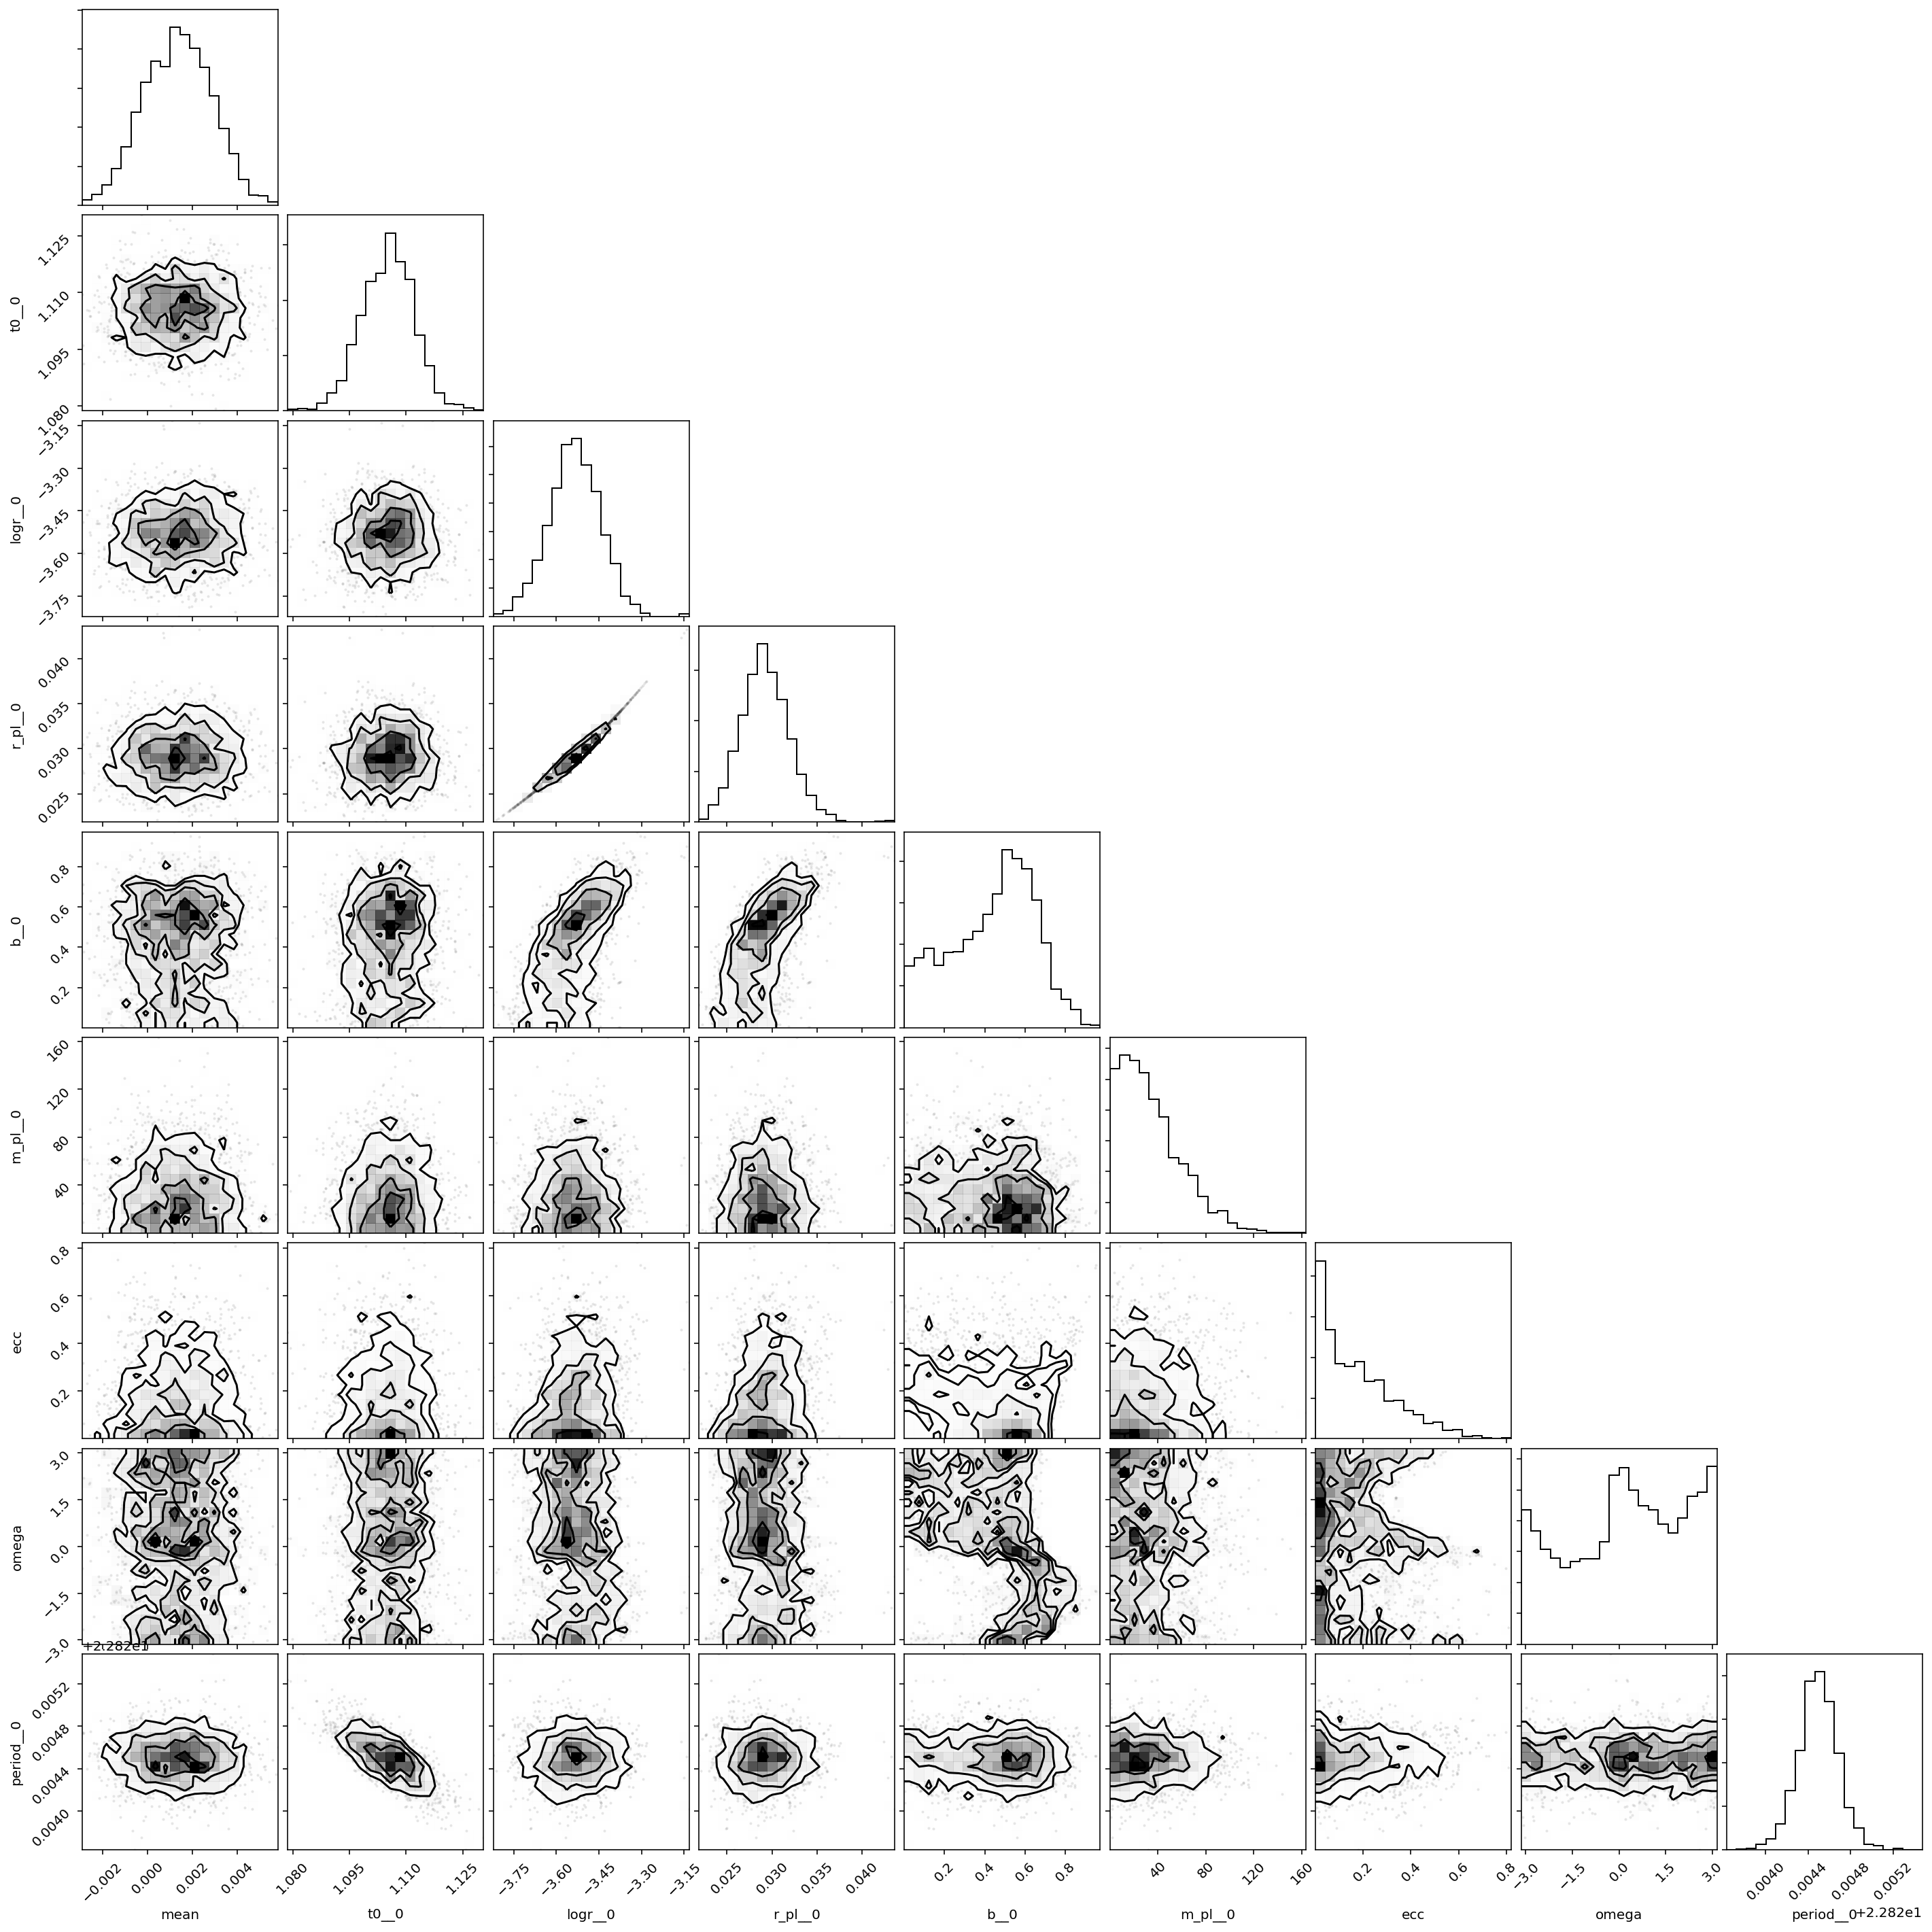

In [46]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=['mean',
 't0',
 'logr',
 'r_pl',
 'b',
'm_pl',
 'ecc',
 'omega',
 'period',]));

In [ ]:
for samp in xo.get_samples_from_trace(trace, 500):
    phase = (x - samp['t0'] - 0.7) % samp['period'] / samp['period']
    sort = np.argsort(phase)
    plt.plot(phase[sort], (samp['light_curves'] + samp['pm_model'])[sort], c='blue', linewidth=0.1, alpha=0.1)
    
plt.xlim(0.94, 1.0)